In [1]:
from os.path import basename, exists
def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print(f"Downloaded: {local}")    

# 4 Cumulative Distribution Functions
---

- **CDF** is useful comparing percentiles, and especially useful for compaing distributions.

In [2]:
import empiricaldist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from thinkstats import decorate

## 4.1 Percentile and Percentile Ranks
- In context to the results in the form of **Percentile Rank**, The percentile rank is the **percentage of people who got the same score as you or lower.**
- ***90th percentile*** --> did as well as or better than 90% fo the people who took the exam.

**EXAMPLE:**

In [3]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/relay.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/Apr25_27thAn_set1.shtml")

In [4]:
# read the results of relay
from relay import read_results

results = read_results()
results.head()

,Place,Div/Tot,Division,Guntime,Nettime,Min/Mile,MPH
0,1,1/362,M2039,30:43,30:42,4:57,12.121212
1,2,2/362,M2039,31:36,31:36,5:06,11.764706
2,3,3/362,M2039,31:42,31:42,5:07,11.726384
3,4,4/362,M2039,32:28,32:27,5:14,11.464968
4,5,5/362,M2039,32:52,32:52,5:18,11.320755


In [5]:
# 1633 runners who finished the race
results.count()

Place       1633
Div/Tot     1633
Division    1633
Guntime     1633
Nettime     1633
Min/Mile    1633
MPH         1633
dtype: int64

In [6]:
# get the speed of each member who participated
# in the race
speeds = results["MPH"].values

In [7]:
# find the required speed of target member
my_result = results.query("Nettime == '42:44'")
my_result

,Place,Div/Tot,Division,Guntime,Nettime,Min/Mile,MPH
96,97,26/256,M4049,42:48,42:44,6:53,8.716707


In [8]:
# as we know the position of us, we can retrieve
# the speed
my_speed = speeds[96]

In [9]:
# count the number of runners at my speed or slower
(speeds <= my_speed).sum()

np.int64(1537)

- The formula for for percentile is given by:
  <div align="center"><samp>
      ( Number of values below x / total number of values ) * 100
  </samp></div>

In [10]:
# use mean to compute the percentage of runners at my speed or slower
(speeds <= my_speed).mean()*100

np.float64(94.12124923453766)

- The result is my percentile rank in the field, which was about 94%

In [11]:
# compute the rank of a particular value in sequence of values.
def percentile_rank(x, seq):
    """Percentile rank of x.

    x: value
    seq: sequence of values

    returns: percentile rank 0-100
    """
    return (seq <= x).mean()*100

- The **Division** Column:
    - The division each runner was in, identified by gender and age range
    - ex: i was in M4049 which includes Male runners from age 40 to 49  

In [12]:
# select the rows for people in my division and extract
# their speeds
my_division = results.query("Division == 'M4049'")
my_division_speed = my_division["MPH"].values

In [13]:
# compute percentile in my division: M4049
percentile_rank(my_speed, my_division_speed)

np.float64(90.234375)

- Percentile is also given by:
```
p = (nth percentile/100) * total number of values in the list
```

- if we are given a percentile rank,

In [14]:
def percentile(p, seq):
    n = len(seq) # number of values in seq
    i = (1 - p / 100) * (n + 1)
    return seq[round(i)]

In [15]:
percentile(90, my_division_speed)

np.float64(8.591885441527447)

- In my division, 90th percentile was about 8.6 MPH 

- Now, some years after I ran that race, I am in the M5059 division
- how fast I would have to run to have the same percentile rank in my new division?

- **ANSWER: convert my percentile rank in the M4049 division, which is about 90.2%, to a speed in the M5059 division.**

In [16]:
next_division = results.query("Division == 'M5059'")
next_division_speeds = next_division["MPH"].values

percentile(90.2, next_division_speeds)

np.float64(8.017817371937639)

In [17]:
# find the person with the same percentile rank as me 
# ran just over 8 mph

In [18]:
next_division.query("MPH > 8.01").tail(1)

,Place,Div/Tot,Division,Guntime,Nettime,Min/Mile,MPH
222,223,18/171,M5059,46:30,46:25,7:29,8.017817


## 4.2 CDFs

- A cumulative distribution function, or CDF, is another way to describe the distribution of a set of values, along with a frequency table or PMF.

**Give a value `x`, the CDF computes the fraction of values less than or equal to `x`.**

**Example :**

In [19]:
t = [1, 2, 2, 3, 5]

In [21]:
from empiricaldist import Pmf
pmf = Pmf.from_seq(t)
pmf

,probs
1,0.2
2,0.4
3,0.2
5,0.2


In [23]:
# compute Cumulative sum of the probablities in Pmf
cdf = pmf.make_cdf()
cdf

,probs
1,0.2
2,0.6
3,0.8
5,1.0


In [24]:
cdf[2]

np.float64(0.6000000000000001)

In [25]:
cdf(2)

array(0.6)

### Visiualize the CDF

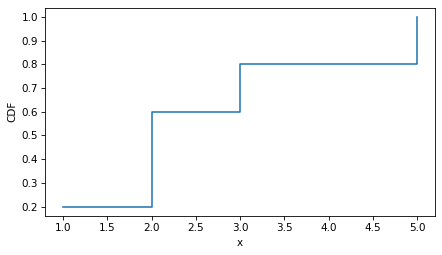

In [26]:
# Visualize the cdf
cdf.step()
decorate(xlabel="x", ylabel="CDF")

### Example 2:

In [29]:
from empiricaldist import Cdf

cdf_speeds = Cdf.from_seq(speeds)

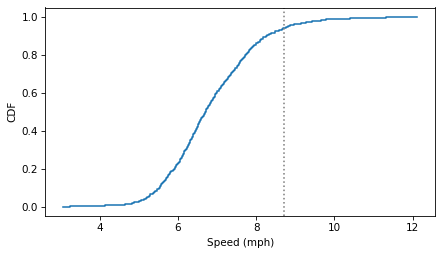

In [30]:
cdf_speeds.step()
plt.axvline(my_speed, ls=":", color="Gray")
decorate(xlabel="Speed (mph)", ylabel="CDF")

- if we look up our speed, the result is the fraction of runners at my speed or slower. if we multiple by 100, we get the percentile rank

In [32]:
cdf_speeds(my_speed)

array(0.94121249)

In [33]:
cdf_speeds(my_speed) * 100

np.float64(94.12124923453766)

**CDF :** given a value, it computes something like a percentile rank, except that it’s a proportion between 0 and 1 rather than a percentage between 0 and 100.

### Inverse the CDF

- Given a **proportion** between 0 and 1, the `reverse` method finds it's corresponding value 

In [35]:
cdf_speeds.inverse(0.5)

array(6.70391061)

- If you have a proportion and you use the inverse CDF to find the corresponding value, the result is called a **quantile**.

## 4.3 Comparing CDFs

In [37]:
import statadict

In [40]:
from nsfg import get_nsfg_groups
live, firsts, others = get_nsfg_groups()

In [41]:
# select total birth weight in pounds of firsts and others
first_weights = firsts["totalwgt_lb"].dropna()
first_weights.mean()

np.float64(7.201094430437772)

In [42]:
other_weight = others["totalwgt_lb"].dropna()
other_weight.mean()

np.float64(7.325855614973262)

- Compare the distribution by plotting the PMFs

In [48]:
first_pmf = Pmf.from_seq(first_weights, name="First")
other_pmf = Pmf.from_seq(other_weight, name="Other")

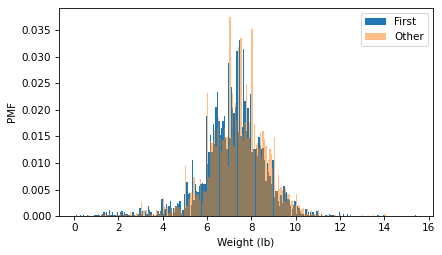

In [49]:
from thinkstats import two_bar_plots

two_bar_plots(first_pmf, other_pmf, width=0.06)
decorate(xlabel='Weight (lb)', ylabel="PMF")

### Binning the data
- In above data, it is hard to compare the two data as there are so many peaks and valleys and it is not visually apparent which distribution has the higher mean.
- To solve these problems we can use **Binning** - that is, dividing the range of quantities into non-overlapping intervals and counting the number of quantities in each bin.
- It is good practice to plot the binning use CDFs

In [51]:
first_cdf = first_pmf.make_cdf()
other_cdf = other_pmf.make_cdf()

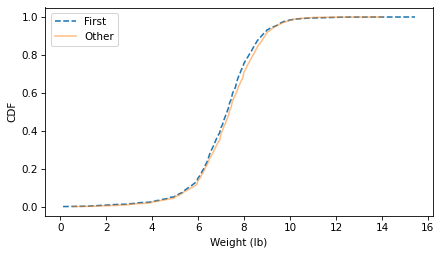

In [52]:
first_cdf.plot(ls="--")
other_cdf.plot(alpha=0.5)
decorate(xlabel="Weight (lb)", ylabel="CDF")

**Conclusion :** The curve of the first babies is consistently to the left of other, which indicates that are first babies are slightly lighter throughout the distribution.

## 4.4 Percentile-Based Statistics

- Percentile based statistics is highly robust as they are less sensitive to outliers than mean, skewness or standard deviations. 

In [53]:
from nsfg import read_stata

dct_file = "2002FemPreg.dct"
dat_file = "2002FemPreg.dat.gz"

preg = read_stata(dct_file, dat_file)

In [54]:
birthwgt_lb = preg["birthwgt_lb"]
birthwgt_oz = preg["birthwgt_oz"]

- `birthwgt_lb` and `birthwgt_oz` contains special values such as 51 and 56 respectively, which has to be a mistake.

In [56]:
# see the missing data from the  above dist
from empiricaldist import Hist
Hist.from_seq(birthwgt_oz).tail(5)

,freqs
birthwgt_oz,
14.0,475
15.0,378
97.0,1
98.0,1
99.0,46


In [57]:
Hist.from_seq(birthwgt_lb).tail(5)

,freqs
birthwgt_lb,
15.0,1
51.0,1
97.0,1
98.0,1
99.0,57


**SCENARIO 1:** Clean the values by replacing them with NaN and then compute the total weight in pounds.

In [60]:
birthwgt_lb_clean = birthwgt_lb.replace([51, 97, 98, 99], np.nan)
birthwgt_oz_clean = birthwgt_oz.replace([97, 98, 99], np.nan)

# convert to pound by dividing by 16
total_weight_clean = birthwgt_lb_clean + birthwgt_oz_clean / 16

**SCENARIO 2:** We neglect the dataa and accidentally compute the total weight with these bogus (not genuine) values.

In [59]:
# bogus total
total_weight_bogus = birthwgt_lb + birthwgt_oz / 16

In [65]:
# the bogus dataset contains only 49 bogus values, 
# which is about 0.5% of the data
count1, count2 = total_weight_clean.count(), total_weight_bogus.count()
diff = count2 - count1

diff, diff / count1 * 100

(np.int64(49), np.float64(0.5421553441026776))

In [66]:
# compute mean of both clean and bogus weights
mean1, mean2 = total_weight_clean.mean(), total_weight_bogus.mean()
mean1, mean2

(np.float64(7.265628457623368), np.float64(7.319680587652691))

In [74]:
# the bogus values have a moderate effect on the mean that is 1%
(mean2 - mean1) / mean2 * 100

np.float64(0.7384492995568888)

In [75]:
# for std deviation
std1, std2 = total_weight_bogus.std(), total_weight_clean.std()
std1, std2

(np.float64(2.096001779161835), np.float64(1.4082934455690173))

- The standard deviation of the bogus data is off by almost 50%, so that's more noticable.

In [76]:
(std1 - std2) / std2 * 100

np.float64(48.83274403900607)

In [77]:
# for skewness
def skewness(seq) -> float:
    """Compute the skewness of a sequence

    seq: sequence

    returns: float skewness
    """
    deviations = seq - seq.mean()
    return np.mean(deviations**3) / seq.std(ddof=0) ** 3

In [79]:
skew1, skew2 = skewness(total_weight_bogus), skewness(total_weight_clean)
skew1, skew2

(np.float64(22.251846195422484), np.float64(-0.5895062687577698))

In [80]:
# how much is skew1 off by?
(skew1 - skew2) / skew2

np.float64(-38.74658112171127)

- Hence, the skewness bogus data is off by almost 40% with a wrong sign 

- The above results conclude that the outliers have:
     - The moderate effect on **Mean**
     - A strong effect on **Standard deviation**
     - A disastrous effec on **Skewness**

- Hence the alternative is to use the percentiles based statistics.
    - The median, which is the 50th percentile, identifies a central point in a distribution, like the mean.

    - The interquartile range, which is the difference between the 25th and 75th percentiles, quantifies the spread of the distribution, like the standard deviation.

    - The quartile skewness uses the quartiles of the distribution (25th, 50th, and 75th percentiles) to quantify the skewness.

### Compute the percentile based statistics

In [81]:
cdf_total_weight_bogus = Cdf.from_seq(total_weight_bogus)
cdf_total_weight_clean = Cdf.from_seq(total_weight_clean)

1. **Compute the 50th percentile (median) :**

In [85]:
# return the inverse of CDF
def median(cdf):
    m = cdf.inverse(0.5)
    return m

In [84]:
median(cdf_total_weight_bogus), median(cdf_total_weight_clean)

(array(7.375), array(7.375))

- The results are identical, so in this case, the outliers have no effect on the median at all.
- Generally, outliers have a smaller effect on the median than ono the mean.

2. **Compute the interquartile range (IQR): difference betwee 70th and 25th percentiles :**

In [86]:
def iqr(cdf):
    low, high = cdf.inverse([0.25, 0.75])
    return high - low

In [87]:
iqr(cdf_total_weight_bogus), iqr(cdf_total_weight_clean)

(np.float64(1.625), np.float64(1.625))

- Generally, outliers have less effect on the IQR than on than standard deviation - in this case they have no effect at all.

3. **Compute the quartile skewness which depends on**:
    - The median
    - The midpoint of 25th and 75th percentiles
    - The semi-IQR which is half of the IQR

In [90]:
def quartile_skewness(cdf):
    low, median, high = cdf.inverse([0.25, 0.5, 0.75])
    midpoint = (high + low) / 2
    semi_iqr = (high - low) / 2
    return (midpoint - median) / semi_iqr

In [91]:
qskew1 = quartile_skewness(cdf_total_weight_bogus)
qskew2 = quartile_skewness(cdf_total_weight_clean)
qskew1, qskew2

(np.float64(-0.07692307692307693), np.float64(-0.07692307692307693))

**CONCLUSION :** Outliers have no to less effect on the percentile-based statistics.

## 4.5 Random numbers

- Cdf objects provide an efficient way to generate random numbers from a distribution. 

In [92]:
# generate the random numbers for distribution
def sample_from_cdf(cdf, n):
    ps = np.random.random(size=n)
    return cdf.inverse(ps)

In [93]:
# generate random sample of running speeds
sample = sample_from_cdf(cdf_speeds, 1001)

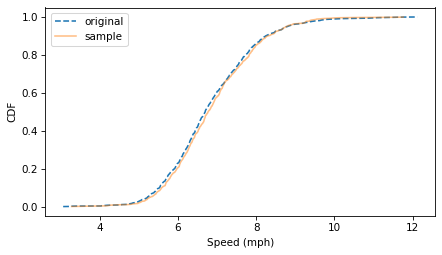

In [94]:
# compare the cdf with original
cdf_sample = Cdf.from_seq(sample)

cdf_speeds.plot(label="original", ls="--")
cdf_sample.plot(label="sample", alpha=0.5)

decorate(xlabel="Speed (mph)", ylabel="CDF")

In [95]:
percentile_ranks = cdf_speeds(sample) * 100

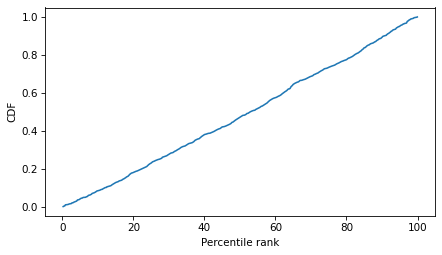

In [96]:
cdf_percentile_ranks = Cdf.from_seq(percentile_ranks)
cdf_percentile_ranks.plot()

decorate(xlabel="Percentile rank", ylabel="CDF")

- The CDF of the percentile ranks is close to a straight line between 0 and 1. And that makes sense, because in any distribution, the proportion with percentile rank less than 50% is 0.5; the proportion with percentile rank less than 90% is 0.9, and so on.